In [ ]:

# Not provided by default in Google Colab
!pip install jaxtyping

# The rest downloads some binary files we'll need
!pip install gdown

# Download all the pretrained models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.6 MB/s eta 0:00:00


In [ ]:
!gdown --id 1F2Z8ziHPaXd_GT_fYe974ySiQVhW0yz0
#!gdown --id 1gGE9MtYvQwCevY9qx-3BEYyoIhDOOBBh
#!gdown --id 1mLEVHleRHiGLHKvu06LE0Oq2Mm6b2lCg
#!gdown --id 1KTZ9m4qmEmUIr-FZMSeVUkd4H8LSB_4b
#!gdown --id 1-Q16KxTkfg5hktOAE-OPgWglgGaaaHFd
#!gdown --id 1RFwpFgpPIOONABfXiHGsMtJdUF1gd10S
#!gdown --id 15BUINas3RQcUVml3QQvoOTVkZjd7IPFS
#!gdown --id 1ASEwxJHndnjFiu2G9tdmn3B5OJkvRQb7
#!gdown --id 1AggdX5mQ9o1QAy9P8_ZpckC8qRDTwPm1
#!gdown --id 1nMjFaMMtijoLidaJSMQoYGnQld5TKp7Q
#!gdown --id 19H7Y50yQsUBj9dWzHWOU8VJJ6zU4cQhA
#!gdown --id 1A5O3OatMM0Lj2m1655Nx1NSwoervV0mS
#!gdown --id 1rKFm7BY8eqQitHYDTrKHzWoFDE_e7fp0
#!gdown --id 1vNM6pD5gc4oOzumGtURp6ASw7nqtwinz
!gdown --id 1_1GFcsjIuWRUcgPU9rMEY5g66K7eX93M

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1F2Z8ziHPaXd_GT_fYe974ySiQVhW0yz0
To: /content/mnist_model_hidden_layer_8
100% 27.8k/27.8k [00:00<00:00, 49.1MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1_1GFcsjIuWRUcgPU9rMEY5g66K7eX93M
From (redirected): https://drive.google.com/uc?id=1_1GFcsjIuWRUcgPU9rMEY5g66K7eX93M&confirm=t&uuid=1f54e1cb-3d89-43d8-8625-103572ce6434
To: /content/mnist_model_hidden_layer_131072
100% 417M/417M [00:05<00:00, 78.5MB/s]


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import einops

In [ ]:

# Some nice preliminary functions for testing.

def assert_with_expect(expected, actual):
    assert expected == actual, f"Expected: {expected} Actual: {actual}"


def assert_list_of_floats_within_epsilon(
    expected: list[float],
    actual: list[float],
    eps=0.0001,
):
    if len(expected) != len(actual):
        raise AssertionError(f"Expected: {expected} Actual: {actual}")
    is_within_eps = True
    for e, a in zip(expected, actual):
        is_within_eps = is_within_eps and abs(e - a) < eps
    if not is_within_eps:
        raise AssertionError(f"Expected: {expected} Actual: {actual}")


def assert_tensors_within_epsilon(
    expected: torch.Tensor,
    actual: torch.Tensor,
    eps=0.001,
):
    if expected.shape != actual.shape:
        raise AssertionError(f"Shapes of tensors do not match! Expected: {expected.shape} Acutal: {actual.shape}")
    differences_within_epsilon = abs(expected - actual) < eps
    if not differences_within_epsilon.all():
        raise AssertionError(f"Values of tensors do not match! Expected: {expected} Actual: {actual}")

In [ ]:

# None of this is code that you will need to write, but you should read this
# over to understand the structure of what kind of nets we'll be training.
#
# Note that we only train with 10,000 images out of the 60,000 image dataset!
# Originally this was because I was hoping to demonstrate some interesting
# double descent phenomena, but unfortunately I ran out of time to do that :(.
# Nonetheless, as we'll see, 10,000 images in the train set is actually enough
# to get to a very well trained neural net!

# hyper-params
BATCH_SIZE = 512
TRAIN_SET_SIZE = 10000
HIDDEN_DIM = 256
EPOCHS = 5000
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# If you set this to True then this will train all the models from scratch,
# otherwise it will look for pre-saved weights and load those instead
TRAIN_FROM_SCRATCH = False
# When training, should we load the entire image set into GPU memory
LOAD_EVERYTHING_INTO_GPU_MEMORY = True

# simple with 3 layers
class SimpleNN(nn.Module):
    def __init__(self, hidden_dim):
        super(SimpleNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.flatten(x)
        x1 = self.relu(self.fc1(x))
        x2 = self.fc2(x1)
        return self.softmax(x2)

In [ ]:

# This is useful for creating reproducible tests for whether you wrote the code
# correctly!
EXAMPLE_SIMPLE_NN_HIDDEN_DIM = 6
example_simple_nn = SimpleNN(EXAMPLE_SIMPLE_NN_HIDDEN_DIM)

# We'll hard-code all of these values so that they are reproducible for tests
with torch.no_grad():
  fc1_weight = einops.rearrange(torch.arange(784 * EXAMPLE_SIMPLE_NN_HIDDEN_DIM), "(x y) -> x y", x=EXAMPLE_SIMPLE_NN_HIDDEN_DIM, y=784)
  fc1_bias = torch.arange(EXAMPLE_SIMPLE_NN_HIDDEN_DIM)
  fc2_weight = einops.rearrange(torch.arange(10 * EXAMPLE_SIMPLE_NN_HIDDEN_DIM), "(x y) -> x y", x=10, y=EXAMPLE_SIMPLE_NN_HIDDEN_DIM)
  fc2_bias = torch.arange(10)
  example_simple_nn.fc1.weight = torch.nn.Parameter(fc1_weight.to(torch.float))
  example_simple_nn.fc1.bias = torch.nn.Parameter(fc1_bias.to(torch.float))
  example_simple_nn.fc2.weight = torch.nn.Parameter(fc2_weight.to(torch.float))
  example_simple_nn.fc2.bias = torch.nn.Parameter(fc2_bias.to(torch.float))

In [ ]:


# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)

hidden_dims = [8, 131072]#[8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072 262144]
models = [SimpleNN(hidden_dim) for hidden_dim in hidden_dims]

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.8MB/s]


In [ ]:

# This is code that you can read if you'd like, but can also just run. It's
# mainly useful if you wanted to train these models yourself.

if LOAD_EVERYTHING_INTO_GPU_MEMORY:
  # We'll load into memory to make this faster
  train_loader_with_entire_dataset = torch.utils.data.DataLoader(train_dataset, batch_size=train_dataset.data.shape[0])
  for batch_idx, (data, target) in enumerate(train_loader_with_entire_dataset):
      data = data[:TRAIN_SET_SIZE].to(DEVICE)
      target = torch.nn.functional.one_hot(target[:TRAIN_SET_SIZE], num_classes=10).to(torch.float)
      target = target.to(DEVICE)

  train_dataset = torch.utils.data.TensorDataset(data, target)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

  test_loader_with_entire_dataset = torch.utils.data.DataLoader(test_dataset, batch_size=test_dataset.data.shape[0])
  for test_data, test_target in test_loader_with_entire_dataset:
      test_data = test_data.to(DEVICE)
      test_target = torch.nn.functional.one_hot(test_target, num_classes=10).to(torch.float)
      test_target = test_target.to(DEVICE)


  test_dataset = torch.utils.data.TensorDataset(test_data, test_target)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)

  # PyTorch DataLoader seems absurdly slow for MNIST dataset sizes
  # It seems to be calling get_item one by one instead of doing batch operations
  # Let's just do a custom list instead
  def generate_simple_loader(dataset, batch_size):
    permuted_indices = torch.randperm(dataset.tensors[0].shape[0])
    permuted_data = dataset.tensors[0][permuted_indices]
    permuted_target = dataset.tensors[1][permuted_indices]
    simple_loader = []
    for i in range(0, permuted_data.shape[0], batch_size):
      simple_loader.append((permuted_data[i:i+batch_size], permuted_target[i:i+batch_size]))
    return simple_loader

  simple_train_loader = generate_simple_loader(train_dataset, BATCH_SIZE)
  simple_test_loader = generate_simple_loader(test_dataset, 10000)

  train_loader = simple_train_loader
  test_loader = simple_test_loader

Processing hidden_dim 8
Processing hidden_dim 131072


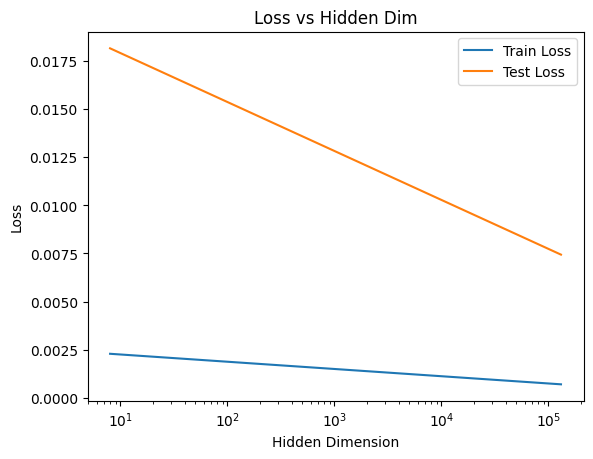

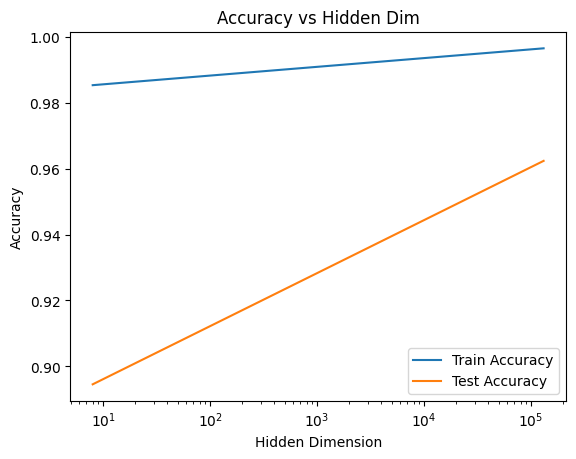

In [ ]:

# This is the actual training loop! Even though this is not code you will need
# to write, you should definitely read this! It's good to understand exactly how
# our model is being trained!
#
# You might notice that we're using MSELoss instead of cross-entropy loss. It
# turns out that this is enough to get quite reasonable models and considerably
# simplifies some of the presentataion to people who have only an introductory
# understanding of neural nets.

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for model in models:
    print(f"Processing hidden_dim {model.hidden_dim}")
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    # Training
    train_loss = 0
    train_accuracy = 0
    train_samples = 0
    if TRAIN_FROM_SCRATCH:
      model = model.to(DEVICE)
      for epoch in range(EPOCHS):
          if LOAD_EVERYTHING_INTO_GPU_MEMORY:
              # Re-shuffle the train loader
              train_loader = generate_simple_loader(train_dataset, BATCH_SIZE)
          for batch_idx, (data, target) in enumerate(train_loader):
              optimizer.zero_grad()
              output = model(data)
              loss = criterion(output, target)
              loss.backward()
              optimizer.step()
    else:
      model.load_state_dict(torch.load(f"mnist_model_hidden_layer_{model.hidden_dim}"))
      model = model.to(DEVICE)
    with torch.no_grad():
      for data, target in train_loader:
          output = model(data)
          train_loss += criterion(output, target).item()
          train_accuracy += (output.argmax(dim=1) == target.argmax(dim=1)).sum().item()
          train_samples += data.shape[0]
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy / train_samples)

    # Testing
    test_loss = 0
    test_accuracy = 0
    test_samples = 0
    with torch.no_grad():
        for test_data, test_target in test_loader:
            output = model(test_data)
            loss = criterion(output, test_target)
            test_loss += loss.item()
            test_accuracy += (output.argmax(dim=1) == test_target.argmax(dim=1)).sum().item()
            test_samples += test_data.shape[0]
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy / test_samples)

plt.plot(hidden_dims, train_losses, label='Train Loss')
plt.plot(hidden_dims, test_losses, label='Test Loss')
plt.xlabel('Hidden Dimension')
plt.ylabel('Loss')
plt.title('Loss vs Hidden Dim')
plt.xscale("log")
plt.legend()
plt.show()

plt.plot(hidden_dims, train_accuracies, label='Train Accuracy')
plt.plot(hidden_dims, test_accuracies, label='Test Accuracy')
plt.xlabel('Hidden Dimension')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Hidden Dim')
plt.xscale("log")
plt.legend()
plt.show()

In [ ]:

if TRAIN_FROM_SCRATCH:
  for dim, model in zip(hidden_dims, models):
    # Save on CPU because this makes it easier to load for more devices
    model = model.to("cpu")
    torch.save(model.state_dict(), f"mnist_model_hidden_layer_{dim}")

In [ ]:

# Go ahead and run this just to make sure

for model in models:
  model = model.to(DEVICE)

In [ ]:

# Fill this out! This should calculate the accuracy of the model for each digit.

def accuracy_by_digit(model, loader):
  # TODO: Implement this!
  #raise NotImplementedError()
  correct = [0] * 10
  total = [0] * 10
  with torch.no_grad():
    for data, target_probs in loader:
      output_probs = model(data)
      output = output_probs.argmax(dim=1)
      target = target_probs.argmax(dim=1)
      for i in range(target.shape[0]):
        total[target[i]] += 1
        if output[i] == target[i]:
          correct[target[i]] += 1
  return [correct[i] / total[i] for i in range(10)]

In [ ]:

# Test it out for our 131072 hidden units model
accuracy_by_digit(models[14], test_loader)

IndexError: list index out of range

In [ ]:

# Test it out for our 8 hidden units model
accuracy_by_digit(models[0], test_loader)

In [ ]:

# Okay now we want to reframe our model using the key-value visualization
# So it's time to implement the functions that will pull out the ith key and ith
# value in our neural net.

def pull_out_ith_key(model, i):
  # TODO: Implement this (it should be just one line)
  # raise NotImplementedError()
  return model.fc1.weight[i]

def pull_out_ith_value(model, i):
  # TODO: Implement this (again should just be one line)
  # raise NotImplementedError()
  return model.fc2.weight[:, i]

# Test code to make sure your code works!
assert_tensors_within_epsilon(expected=torch.arange(1568, 2352), actual=pull_out_ith_key(example_simple_nn, 2))
assert_tensors_within_epsilon(
   expected=torch.tensor([ 2.,  8., 14., 20., 26., 32., 38., 44., 50., 56.]),
   actual=pull_out_ith_value(example_simple_nn, 2)
)

In [ ]:

# This is all a lot of visualization code which you can either read or just run.

#plots the image
def visualize_image(image):
  plt.imshow(image.detach().numpy(), cmap='viridis')
  plt.axis('off')
  plt.show()

#plots the heatmap of a key
def visualize_ith_key(model, i):
  key = pull_out_ith_key(model, i).reshape(28, 28)
  key_bias = model.fc1.bias[i]
  plt.imshow(key.detach().numpy(), cmap='viridis')
  plt.axis('off')
  plt.title(f'Key {i} (bias: {key_bias})')
  plt.show()

#plots a heatmap of a value
def visualize_ith_value(model, i):
  value = pull_out_ith_value(model, i).unsqueeze(0)
  plt.imshow(value.detach().numpy(), cmap='viridis')
  for x in range(value.shape[1]):
    plt.text(x, 0, f'{value[0, x].item():.3f}', ha='center', va='center', color='red', fontsize=6)
  plt.axis('off')
  plt.title(f'Value {i}')
  plt.show()

#visualizes the global value bias for each digit, or the baseline before any interactions
def visualize_value_bias(model):
  value = model.fc2.bias.unsqueeze(0)
  plt.imshow(value.detach().numpy(), cmap='viridis')
  for x in range(value.shape[1]):
    plt.text(x, 0, f'{value[0, x].item():.3f}', ha='center', va='center', color='red', fontsize=6)
  plt.axis('off')
  plt.title(f'Global value bias')
  plt.show()

#combines the above 3 visualization functions
def visualize_ith_key_value(model, i):
  visualize_ith_key(model, i)
  visualize_ith_value(model, i)
  visualize_value_bias(model)

#Shows most influential interaction areas between an image and key
def visualize_element_wise_multi_of_key_image(model, i, image):
  key = model.fc1.weight[i].reshape(28, 28)
  element_wise_multi = key * image
  plt.imshow(element_wise_multi.detach().numpy(), cmap='viridis')
  plt.axis('off')
  plt.title(f'Element-wise multiplication of key {i} with image')
  plt.show()
  print(f"Dot-Product: {torch.sum(element_wise_multi)}")

#combines all of the above visualization functions
def visualize_ith_key_value_on_image(model, i, image):
  visualize_ith_key_value(model, i)
  visualize_element_wise_multi_of_key_image(model, i, image)


In [ ]:

# Now that we have a way of pulling out keys and values, we can put that all
# together to visualize a particular key-value pair!
#
# You might notice that this particular key (if you're using the pre-trained
# model weights) looks visually kind of like a nine, and lo and behold, when you
# go to the value vector that is getting written out, the highest activation is
# a 9!

visualize_ith_key_value(models[14].cpu(), 246)

# Go ahead and play around with other key value pairs and see if you can make
# sense of them.

IndexError: list index out of range

In [ ]:

# It's often useful to find which value vectors we have that tend to write
# strongly for certain kinds of digits.
#
# Here is one very rough stab at the problem that just looks for any value
# vector that has a value over a certain threshold for that digit. We'll quickly
# show a slightly less rough stab in just a moment.

def find_values_for_digit_over_threshold(model, digit, threshold=0.3):
  return torch.tensor([idx for idx in range(model.fc2.weight.shape[1]) if model.fc2.weight[digit, idx] > threshold])

In [ ]:

# This finds those values which have an entry of over 0.4 in the 0 digit place.

find_values_for_digit_over_threshold(models[14], 0, threshold=0.4)

# Feel free to feed this into visualize_ith_key_value to see what that key_value pair looks like!

tensor([51440])

In [ ]:

# Let's see a little bit more of how this key-value reframing of a vanilla
# neural net can help us understand things better.
#
# For example, we might hypothesize that the key which corresponds to a value vector
# that has a large positive value at 0 and small magnitude values for all other digits
# should look like a circle.
#
# Note that this is not obviously true! It might be the case that a model pieces
# together a zero exclusively by piecing together different arcs of a circle
# with no key actually being a full circle.
#
# But we can go ahead and test that right now. First we'll need to build a
# function that can find those key-value pairs which have values concentrated
# mostly on one digit and not as much on the others.
#
# This can be a bit finicky and hard to specify, so we've provided a
# rough-and-tumble version for you to use right here.

def find_values_for_sole_digit(model, digit, digit_threshold=0.16, other_digits_threshold=0.07):
  result = []
  for idx in range(model.fc2.weight.shape[1]):
    other_digits = torch.abs(model.fc2.weight[:, idx])
    other_digits[digit] = 0
    max_of_other_digits = torch.max(other_digits)
    if max_of_other_digits.item() > other_digits_threshold:
      continue
    elif model.fc2.weight[digit, idx] > digit_threshold:
      result.append(idx)
  return torch.tensor(result)

In [ ]:

# So this for example finds those key-value pairs which tend to write very
# strongly to the digit 2 happening, but very little for anything else.
find_values_for_sole_digit(models[14], 2)

tensor([  5485,  11311,  11634,  15459,  15604,  17996,  18248,  21318,  33602,
         33827,  34147,  40629,  42341,  45081,  46158,  47688,  48302,  48622,
         48878,  52226,  57769,  58184,  61879,  62252,  63380,  64617,  67164,
         75087,  79940,  82689,  83456,  86997,  87504,  89855,  92883,  95605,
         97319,  97940, 100654, 100875, 101066, 104672, 104794, 105271, 108030,
        108824, 110081, 110733, 111268, 115880, 117186, 117987, 122741, 126381,
        126759])

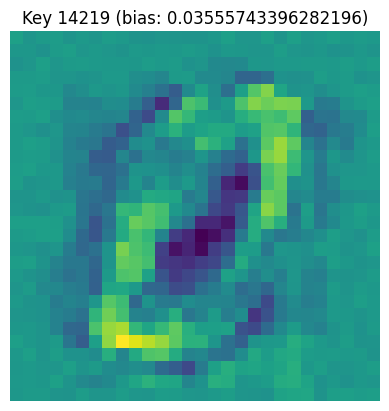

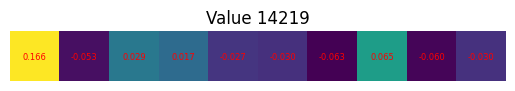

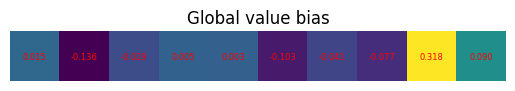

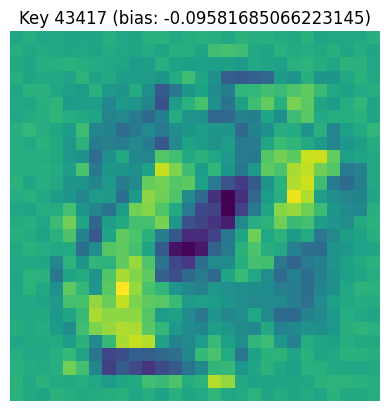

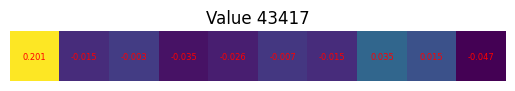

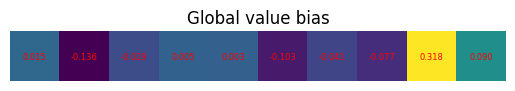

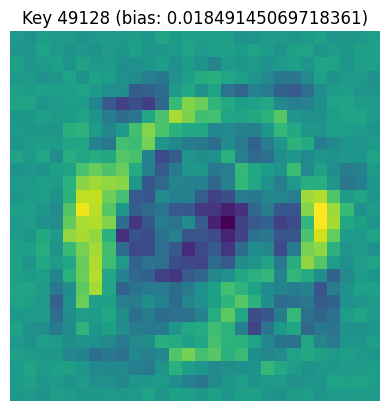

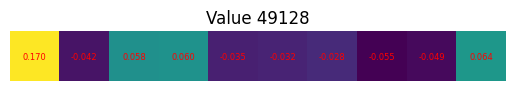

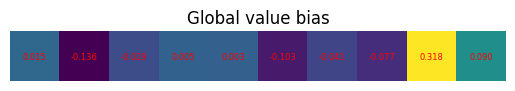

In [ ]:

# Let's now find those key-value pairs which tend to write strongly to the digit
# 0, but very little for everything else, and just analyze the first three of
# those key-value pairs. This will let us validate our hypothesis of whether we
# have keys that are looking for circles, or just fragmentary arcs of circles.

digit_to_analyze = 0

indices_that_fire_mainly_on_select_digit = find_values_for_sole_digit(models[14], digit_to_analyze)
for idx in indices_that_fire_mainly_on_select_digit[:3]:
  visualize_ith_key_value(models[14].to("cpu"), idx)

In [ ]:

# TODO: Look at the results and what they tell you. Talk with your partner or
# group about what you're seeing. Once you've done that, delete this
# NotImplementedError and move on.
# raise NotImplementedError()

In [ ]:

# This function will give us the internal outputs of all the keys and values for
# a given image. In other words this will return the dot product of each key
# with the image (combined with the bias per key) and will also return the
# scaled value vector.
#
# If this is confusing to you, it may be helpful to go back to the slides and
# look a little bit more at the break-down of how exactly we calculate a neural
# net's output using the key-value paradigm.

def compute_kv_outputs_for_image(model, input_image):
  flattened_img = model.flatten(input_image)
  output_after_keys = model.fc1(flattened_img)
  output_after_relu = model.relu(output_after_keys)
  # We ultimately want to multiple all the components of each value vector by
  # the same value, so we need to do a repeat first and then we can do a
  # standard element-wise tensor multiplication
  #
  # But this is just the same as broadcasting, so we just use that instead
  output_after_values = model.fc2.weight * output_after_relu
  return output_after_keys, output_after_values

In [ ]:

def top_indices_by_tail_sum(tensor: torch.Tensor, threshold: float) -> torch.Tensor:
    """
    Given a 1D tensor and a threshold, returns the indices of the largest values
    such that the sum of all smaller values (i.e. the “tail” after that point)
    is <= threshold.
    """
    assert tensor.dim() == 1, "Only works on 1D tensors"
    # Sort descending
    sorted_vals, sorted_idx = tensor.sort(descending=True)
    # Compute cumulative sum of the sorted values
    cumsum = sorted_vals.cumsum(dim=0)
    total = cumsum[-1]
    # tail_sums[i] = sum(sorted_vals[i+1:])
    tail_sums = total - cumsum
    # find the first position where tail_sums <= threshold
    mask = tail_sums <= threshold
    if not mask.any():
        # no cutoff—tail never drops below threshold, so return empty
        return torch.empty(0, dtype=torch.long)
    cutoff = mask.nonzero(as_tuple=False)[0].item()
    # keep everything up to and including cutoff
    return sorted_idx[:cutoff + 1]

# Example
x = torch.tensor([1, 4, 2, 3, 1], dtype=torch.float)
indices = top_indices_by_tail_sum(x, threshold=4)
print(f"{indices=}")  # tensor([1, 3])

#returns the most influential key-value pairs for an image
def list_top_kv_pair_idxs(model, input_image, excess_abs_weight=500):
  _, output_after_values = compute_kv_outputs_for_image(model, input_image)
  abs_values = einops.einsum(torch.abs(output_after_values), "digits num_of_values -> num_of_values")
  indices = top_indices_by_tail_sum(abs_values, excess_abs_weight)
  return indices


In [ ]:

# Let's prove to ourselves that the key-value paradigm of calculating things is equal to the normal layer-by-layer interpretation
def sanity_check_kv_outputs(model, input_image):
  _, output_after_values = compute_kv_outputs_for_image(model, input_image)
  output_plus_bias = einops.einsum(output_after_values, "digits num_of_values -> digits") + model.fc2.bias
  print(f"{output_plus_bias.softmax(dim=-1)=}")
  print(f"{model(input_image)=}")

# You should see that the two print statements print the same values
sanity_check_kv_outputs(models[14], train_dataset[0][0].cpu())

In [ ]:

# This will list the key-value pairs that write the value vectors with the largest magnitude.
# This is a proxy for
list_top_kv_pair_idxs(models[14], train_dataset[0][0].cpu(), 7000)

tensor([ 22650,  97361,  22655, 116764,  96894,  45001,  60569,  18934, 119515,
        111355, 130864,  67235,  88466,   7986,  48085, 120645,  20950,  91106,
         81859, 105433,  98783,  81742,  73848,   6328,  49395,  43918,   8756,
         40372,   8026, 102324,  96621,   8097,  27756,  59921,  95901,  41560,
        124669,  32428,  33348,  31593,  73243,  54181,  40183, 122513,  30664,
         78467,  43553,   8997,  84512,  39740, 109001,  55070,  31828,  81307,
         64836,  67838,  15396, 121499,  59015,  59769,  29606,  91146,   4189,
         79263, 101173, 124844,  87343,  27454, 128883,  40796, 114452, 119153,
         79275,   5792,  30186,  28519, 120306])

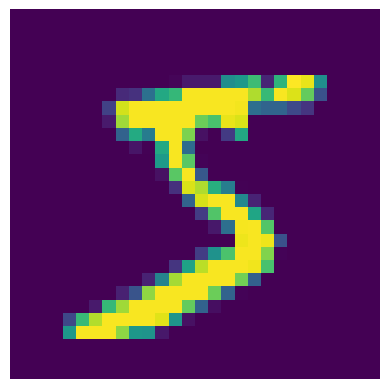

In [ ]:

visualize_image(train_dataset[0][0].cpu().squeeze())

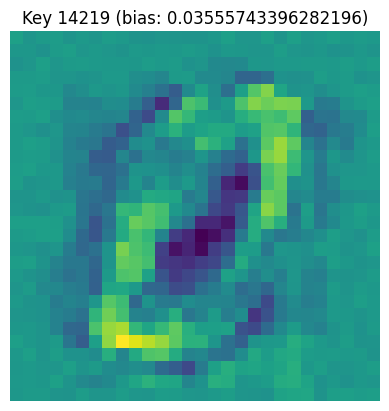

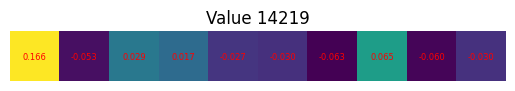

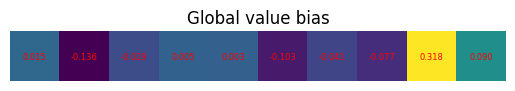

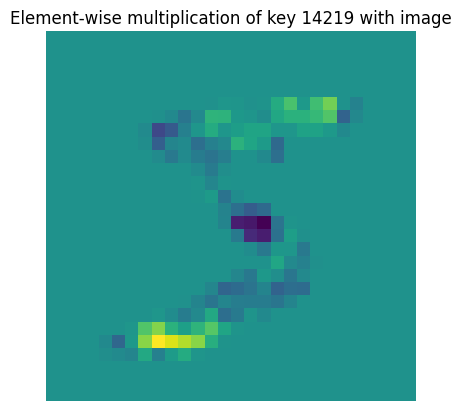

Dot-Product: -1.2124989032745361


In [ ]:

visualize_ith_key_value_on_image(models[14], 14219, train_dataset[0][0].cpu().squeeze())

In [ ]:

#finds the most variable key-value pairs
def sort_by_value_variance(model, input_image):
  _, output_after_values = compute_kv_outputs_for_image(model, input_image)
  print(f"{torch.var(output_after_values, dim=-1, keepdim=True).shape=}")
  variances = torch.var(output_after_values, dim=0, keepdim=True)
  var_values, var_indices = torch.sort(variances, dim=-1, descending=True)
  print(f"{var_indices.shape=}")
  return var_indices

top_5_kv_pairs_by_value_variance = sort_by_value_variance(models[14], train_dataset[0][0].cpu())[:, :5]

IndexError: list index out of range

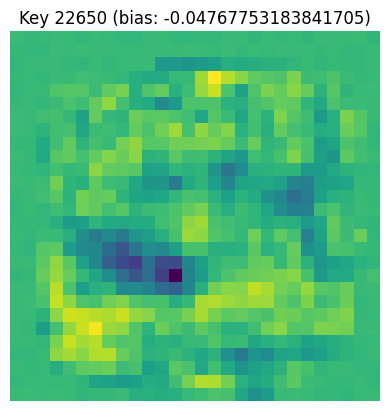

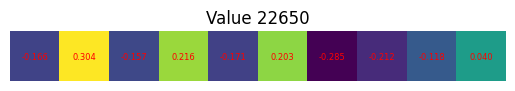

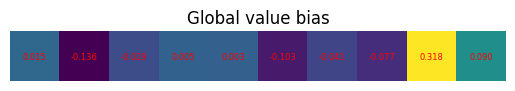

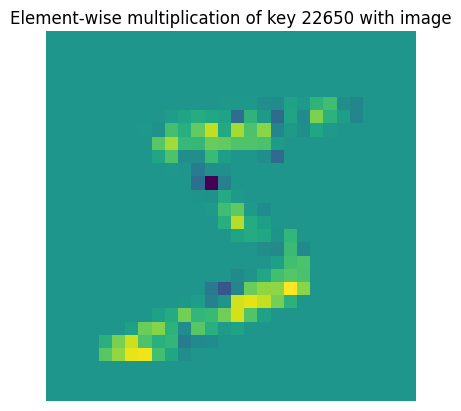

Dot-Product: 7.203427791595459


In [ ]:

visualize_ith_key_value_on_image(models[14], 22650, train_dataset[0][0].cpu().squeeze())

In [ ]:

#finds key-value pairs that react almost only to one digit
def find_values_with_mostly_zeroes(model):
  values = model.fc2.weight
  num_of_elems_close_to_0 = torch.abs(values) < 0.05
  print(f"{values.shape=}")
  print(f"{num_of_elems_close_to_0.shape=}")
  nine_elems_close_to_0 = torch.sum(num_of_elems_close_to_0, dim=0) == 9
  indices_with_one_non_zero_elem = torch.nonzero(nine_elems_close_to_0).squeeze()
  large_total_sums = torch.nonzero(torch.sum(values, dim=0) > 0.18).squeeze()
  print(f"{indices_with_one_non_zero_elem.shape=}")
  large_total_sum_and_nine_elems_close_to_0 = indices_with_one_non_zero_elem[torch.isin(indices_with_one_non_zero_elem, large_total_sums)]
  print(f"{large_total_sum_and_nine_elems_close_to_0=}")

find_values_with_mostly_zeroes(models[14])

IndexError: list index out of range

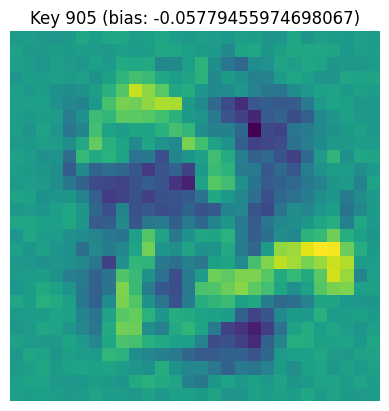

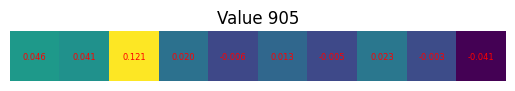

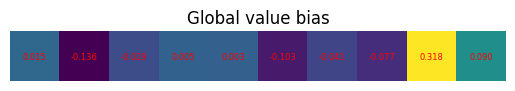

In [ ]:

visualize_ith_key_value(models[14].cpu(), 905)

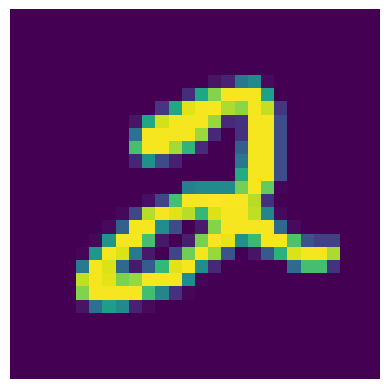

In [ ]:

visualize_image(train_dataset[5][0].cpu().squeeze())

In [ ]:

list_top_kv_pair_idxs(models[14], train_dataset[5][0].cpu(), 5500)

tensor([ 32951,  86484, 113917,  46812,  31062,  18934,   2669,  20950, 119802,
        103534,  23600,   8958,  18964, 106612,  16149,  48676,   8364, 101855,
         38905,  72582,   1870, 105267,  52777,  22118,  33428, 118065,  97438,
         87946, 128605,  82265])

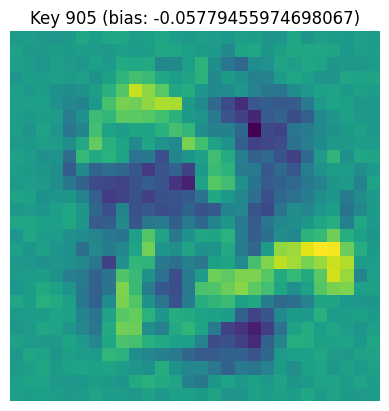

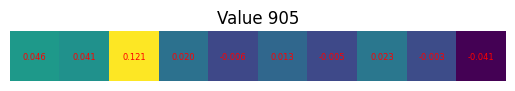

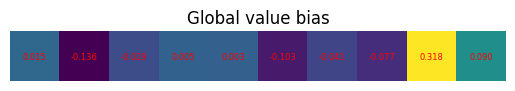

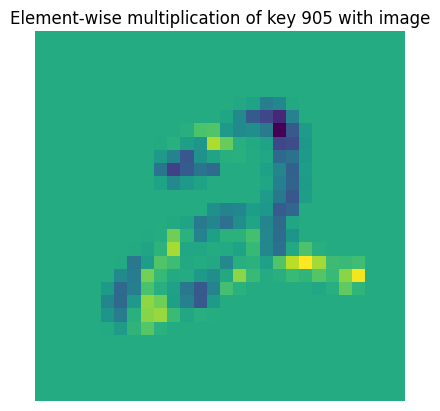

Dot-Product: -3.8568274974823


In [ ]:

visualize_ith_key_value_on_image(models[14].cpu(), 905, train_dataset[5][0].cpu().squeeze())

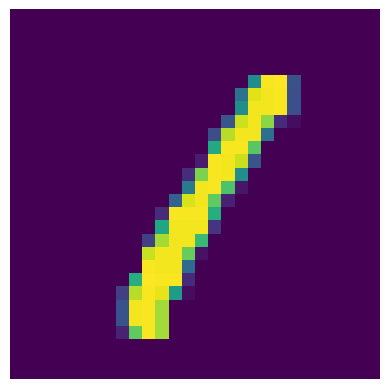

In [ ]:

visualize_image(train_dataset[3][0].cpu().squeeze())

In [ ]:

list_top_kv_pair_idxs(models[0].cpu(), train_dataset[3][0].cpu(), 10_000)

tensor([6])

In [ ]:

models[0].cpu()(train_dataset[3][0].cpu()).squeeze()

tensor([1.0671e-13, 9.9990e-01, 1.0068e-04, 1.4655e-09, 3.5295e-15, 2.3604e-12,
        3.0281e-10, 6.7490e-12, 2.5823e-07, 5.7540e-15],
       grad_fn=<SqueezeBackward0>)

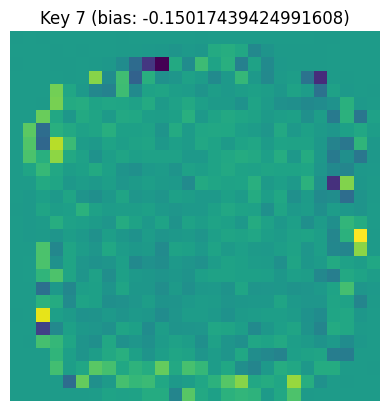

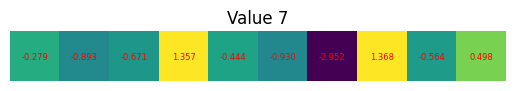

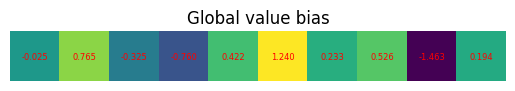

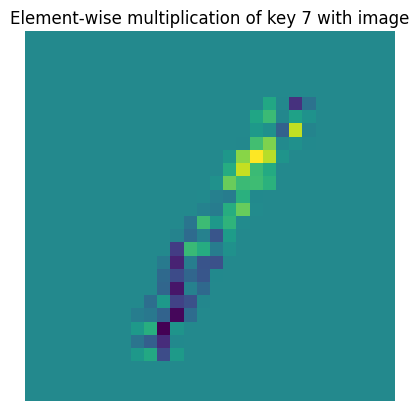

Dot-Product: 1.0531234741210938


In [ ]:

visualize_ith_key_value_on_image(models[0].cpu(), 7, train_dataset[3][0].cpu().squeeze())

In [ ]:

# This finds the image that activates mostly strongly for a given key.

def sort_highest_activating_image_for_key(model, key_value_idx, input_images):
  key = model.fc1.weight[key_value_idx, :]
  print(f"{input_images.shape=}")
  flattened_images = model.flatten(input_images)
  dot_products = einops.einsum(key, flattened_images, "key_dim, batch key_dim -> batch")
  _, indices_by_dot_product = torch.sort(dot_products, descending=True)
  return indices_by_dot_product

train_images = torch.stack([img for img, _ in train_dataset])

result = sort_highest_activating_image_for_key(models[14].cpu(), 905, train_images.cpu())

print(f"{result=}")

visualize_image(train_images[result][5].cpu().squeeze())

IndexError: list index out of range

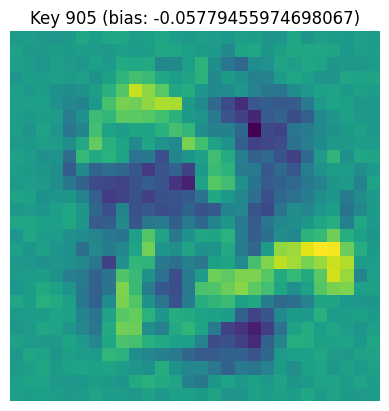

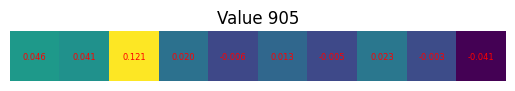

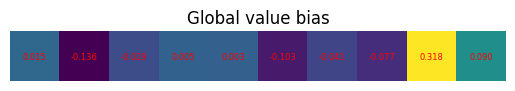

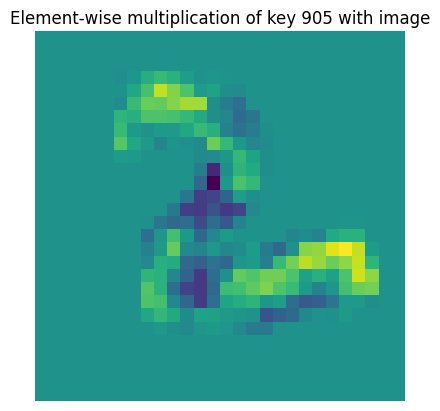

Dot-Product: 2.1255877017974854


In [ ]:

visualize_ith_key_value_on_image(models[14].cpu(), 905, train_dataset[2019][0].cpu().squeeze())

In [ ]:

import copy

def delete_by_index(x: torch.Tensor, indices, dim: int = 0):
    """
    Return a new tensor with the specified indices removed along `dim`.

    Args
    ----
    x (torch.Tensor): input tensor
    indices (Sequence[int] | torch.Tensor): positions to delete
    dim (int): dimension along which to delete (default 0)

    Example
    -------
    >>> t = torch.tensor([[10, 11],
    ...                   [20, 21],
    ...                   [30, 31],
    ...                   [40, 41]])
    >>> delete_by_index(t, [1, 3])
    tensor([[10, 11],
            [30, 31]])
    """
    # Ensure we have a 1-D LongTensor of unique, sorted indices on the same device
    idx = torch.as_tensor(indices, dtype=torch.long, device=x.device).unique().sort().values

    # Build a boolean mask that is False at the indices we want to drop
    mask_shape = [1] * x.dim()
    mask_shape[dim] = x.size(dim)
    mask = torch.ones(mask_shape, dtype=torch.bool, device=x.device).squeeze()
    mask[idx] = False

    return x[mask] if dim == 0 else x.transpose(0, dim)[mask].transpose(0, dim)

#removes a certain key from the model
def knock_out_ith_key(model: SimpleNN, key_value_idx: torch.Tensor) -> SimpleNN:
  with torch.no_grad():
    new_model = copy.deepcopy(model)
    new_model.fc1 = torch.nn.Linear(model.fc1.in_features, model.fc1.out_features - key_value_idx.shape[0])
    new_model.fc2 = torch.nn.Linear(model.fc2.in_features - key_value_idx.shape[0], model.fc2.out_features)
    new_model.fc1.weight = torch.nn.Parameter(delete_by_index(model.fc1.weight, key_value_idx))
    new_model.fc1.bias = torch.nn.Parameter(delete_by_index(model.fc1.bias, key_value_idx))
    new_model.fc2.weight = torch.nn.Parameter(delete_by_index(model.fc2.weight, key_value_idx, dim=1))
    return new_model

In [ ]:

# Find all those key-value pairs which activate a lot for zero
all_values_that_activate_significantly_for_zero = find_values_for_digit_over_threshold(models[14], 0, threshold=0.1)

In [ ]:

# Let's see if we can just selectively knock those out!
model_with_0_knocked_out = knock_out_ith_key(models[14], all_values_that_activate_significantly_for_zero)

In [ ]:

# And now we see that the model is basically entirely incapable of recognizing 0, but the rest of its capabilities are left intact!
accuracy_by_digit(model_with_0_knocked_out.to(DEVICE), test_loader)

[0.0020408163265306124,
 0.9903083700440528,
 0.939922480620155,
 0.9445544554455445,
 0.9786150712830958,
 0.9753363228699552,
 0.9572025052192067,
 0.9766536964980544,
 0.9620123203285421,
 0.9355797819623389]

In [ ]:
#finds key-value pairs that react not at all
def find_values_with_almost_all_zeroes(model):
  values = model.fc2.weight
  num_of_elems_close_to_0 = torch.abs(values) < 0.05
  print(f"{values.shape=}")
  print(f"{num_of_elems_close_to_0.shape=}")
  all_elems_close_to_0 = torch.sum(num_of_elems_close_to_0, dim=0) == 10
  indices_with_no_non_zero_elem = torch.nonzero(all_elems_close_to_0).squeeze()
  print(f"{indices_with_no_non_zero_elem=}")
  return indices_with_no_non_zero_elem

find_values_with_almost_all_zeroes(models[14])

IndexError: list index out of range

In [ ]:

#finds key-value pairs where the value is small for every digit
def find_mostly_zero_values(model, threshold=0.05):
  return torch.tensor([idx for idx in range(model.fc2.weight.shape[1]) if (torch.abs(model.fc2.weight[:, idx]) < threshold).all()])

In [ ]:
#baseline
all_values_that_are_mostly_zero_base = find_mostly_zero_values(models[1], threshold=0.0)

KeyboardInterrupt: 

In [ ]:

model_with_mostly_zero_values_knocked_out_baseline = knock_out_ith_key(models[14], all_values_that_are_mostly_zero_base)
print(f"{model_with_mostly_zero_values_knocked_out_baseline.fc2.weight.shape}")

torch.Size([10, 131072])


In [ ]:
accuracy_by_digit(model_with_mostly_zero_values_knocked_out_baseline.to(DEVICE), test_loader)

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.88 GiB. GPU 0 has a total capacity of 14.74 GiB of which 3.50 GiB is free. Process 20394 has 11.24 GiB memory in use. Of the allocated memory 6.34 GiB is allocated by PyTorch, and 4.78 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
#0.05
all_values_that_are_mostly_zero_05 = find_mostly_zero_values(models[1], threshold=0.05)

In [ ]:

model_with_mostly_zero_values_knocked_out_05 = knock_out_ith_key(models[1], all_values_that_are_mostly_zero_05)
print(f"{model_with_mostly_zero_values_knocked_out_05.fc2.weight.shape}")

torch.Size([10, 50879])


In [ ]:
accuracy_by_digit(model_with_mostly_zero_values_knocked_out_05.to(DEVICE), test_loader)

[0.9826530612244898,
 0.9876651982378855,
 0.9486434108527132,
 0.9356435643564357,
 0.9684317718940937,
 0.9663677130044843,
 0.9603340292275574,
 0.9698443579766537,
 0.9527720739219713,
 0.9494549058473737]

In [ ]:
#0.10
all_values_that_are_mostly_zero_10 = find_mostly_zero_values(models[1], threshold=0.1)

In [ ]:

model_with_mostly_zero_values_knocked_out_10 = knock_out_ith_key(models[1], all_values_that_are_mostly_zero_10)
print(f"{model_with_mostly_zero_values_knocked_out_10.fc2.weight.shape}")

torch.Size([10, 38952])


In [ ]:
accuracy_by_digit(model_with_mostly_zero_values_knocked_out_10.to(DEVICE), test_loader)

[0.9836734693877551,
 0.9876651982378855,
 0.9486434108527132,
 0.9376237623762376,
 0.9694501018329938,
 0.9663677130044843,
 0.9613778705636743,
 0.9698443579766537,
 0.9527720739219713,
 0.9494549058473737]

In [ ]:
#0.15
all_values_that_are_mostly_zero = find_mostly_zero_values(models[1], threshold=0.15)

In [ ]:

model_with_mostly_zero_values_knocked_out_15 = knock_out_ith_key(models[1], all_values_that_are_mostly_zero)
print(f"{model_with_mostly_zero_values_knocked_out_15.fc2.weight.shape}")

torch.Size([10, 28294])


In [ ]:
accuracy_by_digit(model_with_mostly_zero_values_knocked_out_15.to(DEVICE), test_loader)

[0.9826530612244898,
 0.9876651982378855,
 0.9486434108527132,
 0.9396039603960396,
 0.9745417515274949,
 0.9697309417040358,
 0.9613778705636743,
 0.9688715953307393,
 0.9496919917864476,
 0.9494549058473737]

In [ ]:
#0.20
all_values_that_are_mostly_zero_20 = find_mostly_zero_values(models[1], threshold=0.2)

In [ ]:
model_with_mostly_zero_values_knocked_out_20 = knock_out_ith_key(models[1], all_values_that_are_mostly_zero_20)
print(f"{model_with_mostly_zero_values_knocked_out_20.fc2.weight.shape}")

torch.Size([10, 17434])


In [ ]:
accuracy_by_digit(model_with_mostly_zero_values_knocked_out_20.to(DEVICE), test_loader)

[0.976530612244898,
 0.9885462555066079,
 0.9534883720930233,
 0.9504950495049505,
 0.9796334012219959,
 0.9742152466367713,
 0.9592901878914405,
 0.9737354085603113,
 0.944558521560575,
 0.9425173439048563]

In [ ]:
[0.9826530612244898,
 0.9876651982378855,
 0.9486434108527132,
 0.9356435643564357,
 0.9684317718940937,
 0.9663677130044843,
 0.9603340292275574,
 0.9698443579766537,
 0.9527720739219713,
 0.9494549058473737]

[0.9826530612244898,
 0.9876651982378855,
 0.9486434108527132,
 0.9356435643564357,
 0.9684317718940937,
 0.9663677130044843,
 0.9603340292275574,
 0.9698443579766537,
 0.9527720739219713,
 0.9494549058473737]

In [ ]:

#finds the key-value pairs where the values for each digit are mostly similar to each other
def find_mostly_similar_values(model, epsilon=0.05):
    possible_idx = []

    for idx in range(model.fc2.weight.shape[1]):
      if (torch.max(model.fc2.weight[:, idx]) - torch.min(model.fc2.weight[:, idx]) < epsilon):
        possible_idx.append(idx)

    return torch.tensor(possible_idx)

In [ ]:
values_with_same = find_mostly_similar_values(models[1], epsilon=0.05)

In [ ]:
model_with_similar_values_knocked = knock_out_ith_key(models[1], values_with_same)
print(f"{model_with_similar_values_knocked.fc2.weight.shape}")

torch.Size([10, 61575])


In [ ]:
accuracy_by_digit(model_with_similar_values_knocked.to(DEVICE), test_loader)

[0.9826530612244898,
 0.9876651982378855,
 0.9486434108527132,
 0.9356435643564357,
 0.9684317718940937,
 0.9663677130044843,
 0.9603340292275574,
 0.9698443579766537,
 0.9527720739219713,
 0.9494549058473737]

In [ ]:
values_with_same = find_mostly_similar_values(models[1], epsilon=0.1)

In [ ]:
model_with_similar_values_knocked = knock_out_ith_key(models[1], values_with_same)
print(f"{model_with_similar_values_knocked.fc2.weight.shape}")

torch.Size([10, 48275])


In [ ]:
accuracy_by_digit(model_with_similar_values_knocked.to(DEVICE), test_loader)

[0.9826530612244898,
 0.9876651982378855,
 0.9486434108527132,
 0.9356435643564357,
 0.9684317718940937,
 0.9663677130044843,
 0.9603340292275574,
 0.9698443579766537,
 0.9527720739219713,
 0.9494549058473737]

In [ ]:
values_with_same_20 = find_mostly_similar_values(models[1], epsilon=0.2)

In [ ]:
model_with_similar_values_knocked_20 = knock_out_ith_key(models[1], values_with_same_20)
print(f"{model_with_similar_values_knocked_20.fc2.weight.shape}")

torch.Size([10, 35414])


In [ ]:
accuracy_by_digit(model_with_similar_values_knocked_20.to(DEVICE), test_loader)

[0.9836734693877551,
 0.9876651982378855,
 0.9486434108527132,
 0.9376237623762376,
 0.9704684317718941,
 0.968609865470852,
 0.9613778705636743,
 0.9688715953307393,
 0.9527720739219713,
 0.9494549058473737]

In [ ]:
values_with_same_50 = find_mostly_similar_values(models[1], epsilon=0.5)

In [ ]:
model_with_similar_values_knocked_50 = knock_out_ith_key(models[1], values_with_same_50)
print(f"{model_with_similar_values_knocked_50.fc2.weight.shape}")

torch.Size([10, 4586])


In [ ]:
accuracy_by_digit(model_with_similar_values_knocked_50.to(DEVICE), test_loader)

[0.7642857142857142,
 0.9436123348017621,
 0.9108527131782945,
 0.9841584158415841,
 0.9877800407331976,
 0.9585201793721974,
 0.8768267223382046,
 0.9406614785992218,
 0.8613963039014374,
 0.8235877106045589]

In [ ]:
all_values_that_are_mostly_zero_10 = find_mostly_zero_values(models[1], threshold=0.1)

In [ ]:

model_with_mostly_zero_values_knocked_out_10 = knock_out_ith_key(models[1], all_values_that_are_mostly_zero_10)
print(f"{model_with_mostly_zero_values_knocked_out_10.fc2.weight.shape}")

torch.Size([10, 38952])


In [ ]:
both_values_close_to_zero_and_similar = find_mostly_similar_values(model_with_mostly_zero_values_knocked_out_10, epsilon=0.3)

In [ ]:
both_values_close_to_zero_and_similar_10 = knock_out_ith_key(model_with_mostly_zero_values_knocked_out_10, both_values_close_to_zero_and_similar)
print(f"{both_values_close_to_zero_and_similar_10.fc2.weight.shape}")

torch.Size([10, 22701])


In [ ]:
accuracy_by_digit(both_values_close_to_zero_and_similar_10.to(DEVICE), test_loader)

[0.9826530612244898,
 0.9876651982378855,
 0.9505813953488372,
 0.9435643564356435,
 0.9765784114052953,
 0.9719730941704036,
 0.9592901878914405,
 0.9708171206225681,
 0.9455852156057495,
 0.9484638255698712]